## <ins>The Mountain car problem</ins> 

The Mountain Car problem is an environment where gravity exists (what a surprise) and the goal is to help a poor car win the battle against it.

The car needs to escape the valley where it got stuck. The car’s engine is not powerful enough to climb up the mountain in a single pass, so the only way to make it is to drive back and forth and build sufficient momentum.

**<ins>Why this problem?</ins>**

The philosophy of this course is to progressively add complexity. Step-by-step.

Today’s environment represents a small but relevant increase in complexity when compared to theTaxi-v3 environment from part 2.

**<ins>But, what exactly is harder here?</ins>**

As we saw in part 2, the difficulty of a reinforcement learning problem is directly related to the size of
 - the action space: how many actions can the agent choose from at each step?
 - the state space: in how many different environment configurations can the agent find itself?
 
For small environments with a finite (and small) number of actions and states, we have strong guarantees that algorithms like Q-learning will work well. These are called tabular or discrete environments.

Q-functions are essentially matrices with as many rows as states and columns as actions. In these small worlds, our agents can easily explore the states and build effective policies. As the state space and (especially) the action space becomes larger, the RL problem becomes harder to solve.

Today’s environment is **<ins>NOT</ins>** tabular. However, we will use a discretization “trick” to transform it into a tabular one, and then solve it.
Let’s first get familiar with the environment!

In [3]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
# LOAD ENVIRONMENT AND DEPENDENCIES
import numpy as np
from matplotlib import pyplot as plt
import gym
env = gym.make('MountainCar-v0')

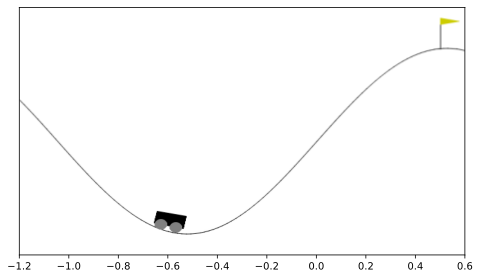

In [5]:
# PLOT ONE FRAME
env.reset()
frame = env.render(mode='rgb_array')

fig, ax = plt.subplots(figsize=(8, 6))
ax.axes.yaxis.set_visible(False)
ax.imshow(frame, extent=[env.min_position, env.max_position, 0, 1])


In [7]:
# INVESTIGATE ACTION SPACE
print("Action Space {}".format(env.action_space))

Action Space Discrete(3)


### ACTION SPACE
- `0` Accelerate to the left
- `1` Don't accelerate / do nothing
- `2` Accelerate to the right

In [ ]:
# INVESTIGATE THE STATE SPACE 

print("State Space {}".format(env.observation_space))
print(f'Position ranges from {env.min_position} to {env.max_position}')
print(f'Velocity ranges from {-env.max_speed} to {env.max_speed}')

# State Space Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
# Position ranges from -1.2 to 0.6
# Velocity ranges from -0.07 to 0.07

### STATE SPACE 
This means: two numbers determine the state of the car:
 - Its **position**, which ranges from `-1.2` to `0.6`
 - Its **speed**, which ranges from `-0.07` to `0.07`.

 The state is given by 2 continuous numbers. This is a remarkable difference with respect to the Taxi-v3 environment from part 2. We will later see how to handle this.

### REWARDS

 - A reward of `-1` is awarded if the *position of the car is less than 0.5*.
 - The episode **ends** once the *car’s position is above 0.5*, **or** the *max number of steps has been reached*: `n_steps >= env._max_episode_steps`
 - A default negative reward of `-1` encourages the car to escape the valley as fast as possible.

In general, I recommend you check Open AI Gym environments’ implementations [directly in Github](https://github.com/openai/gym/tree/master/gym/envs) to understand states, actions, and rewards.

The code is well documented and can help you quickly understand everything you need to start working on your RL agents. MountainCar ‘s implementation is here, for example.

### BASELINE

Reinforcement learning problems can grow in complexity pretty easily. Well-structured code is your best ally to keep complexity under control.

Today we are going to level up our Python skills and use a `BaseAgent` class for all our agents. From this `BaseAgent` class, we will derive our `RandomAgent` and `SarsaAgent` classes.

![](diagram.png)

`BaseAgent` is an abstract class we define below 

In [4]:
import pickle
from pathlib import Path
from abc import ABC, abstractmethod

class BaseAgent(ABC):

    @abstractmethod
    def get_action(self, state):
        pass

    @abstractmethod
    def update_parameters(self, state, action, reward, next_state):
        pass

    def save_to_disk(self, path: Path):
        """
        Saves python object to disk using a binary format
        """
        with open(path, "wb") as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)

    @classmethod
    def load_from_disk(cls, path: Path):
        """
        Loads binary format into Python object.
        """
        with open(path, "rb") as f:
            dump = pickle.load(f)

        return dump

It has 4 methods.

Two of its methods are abstract, which means we are forced to implement them when we derived our RandomAgent and SarsaAgent from the BaseAgent:

`get_action(self, state)` → returns the action to perform, depending on the state.

`update_parameters(self, state, action, reward, next_state)` → adjusts agent parameters using experience. Here we will implement the SARSA formula.

The other two methods let us save/load the trained agent to/from the disk.

`save_to_disk(self, path)`

`load_from_disk(cls, path)`

As we start implementing more complex models and training times increase, it is going to be a great idea to save checkpoints during training.

From this `BaseAgent` class, we can define the `RandomAgent` as follows:

In [5]:
class RandomAgent(BaseAgent):

    def __init__(self, env):
        self.env = env 
    
    def get_action(self, state) -> int:
        return self.env.action_space.sample()
    
    def update_parameters(self, state, action, reward, next_state):
        pass

In [6]:
from typing import Tuple, List, Callable, Union, Optional
import random
from tqdm import tqdm

def evaluate(agent, env, n_episodes: int, epsilon: Optional[float] = None) -> Tuple[List, List]:

    # For plotting metrics
    reward_per_episode = []
    max_position_per_episode = []

    for i in tqdm(range(0, n_episodes)):

        state = env.reset()

        rewards = 0
        max_position = -99

        done = False
        while not done:

            if (epsilon is not None) and (random.uniform(0, 1) < epsilon):
                action = env.action_space.sample()
            else:
                action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)

            agent.update_parameters(state, action, reward, next_state)

            rewards += reward
            if next_state[0] > max_position:
                max_position = next_state[0]

            state = next_state

        reward_per_episode.append(rewards)
        max_position_per_episode.append(max_position)

    return reward_per_episode, max_position_per_episode

In [7]:
agent = RandomAgent(env)
n_episodes = 100
rewards, max_positions = evaluate(agent, env, n_episodes)

100%|██████████| 100/100 [00:02<00:00, 44.43it/s]


In [8]:
# SUCCESS RATE
n_completed = sum([1 if m > 0.5 else 0 for m in max_positions])
print(f'{n_completed} success out of {n_episodes} attempts')

0 success out of 100 attempts


We can see how far the agent got in each episode with the following histogram:

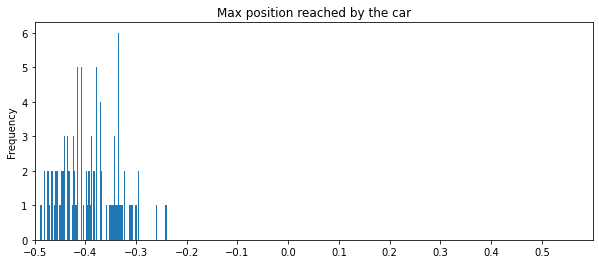

In [9]:
import matplotlib.pyplot as plt
import pandas as pd


fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Max position reached by the car")    
ax.set(xlim=(-0.5, 0.6), xticks=np.arange(-0.5, 0.6, 0.1))
pd.Series(max_positions).plot(kind='hist', bins=100)

plt.show()

In these 100 runs our RandomAgentdid not cross the 0.5 mark. Not a single time

When you run this code on your local machine you will get slightly different results, but the percentage of completed episodes above 0.5 will be very far from 100% in any case.

### SARSA AGENT TIME

SARSA (by Rummery and Niranjan) is an algorithm to train reinforcement learning agents by learning the optimal q-value function.

It was published in 1994, two years after Q-learning (by Chris Walkins and Peter Dayan).

SARSA stands for **State Action Reward State Action.**

Both SARSA and Q-learning exploit the Bellman equation to iteratively find better approximations to the optimal q-value function `Q*(s, a)`

![](form1.png)

but they do it slightly differently.

If you remember from part 2, the update formula for Q-learning is

![](form2.png)

This formula is a way to compute a new estimate of the q-value that is closer to

![](form3.png)


This quantity is a **<ins>target</ins>** 🎯 we want to correct our old estimate towards. It’s an *estimation* of the optimal q-value we should aim at, that changes as we train the agent and our q-value matrix gets updated.

 - Reinforcement learning problems often look like supervised ML problems, but with **<ins>moving targets</ins>** 🏃 🎯

SARSA has a similar update formula but with a different **<ins>target</ins>**

![](form4.png)


## SARSA’s target:

![](form5.png)

It depends also on the action `a’` the agent will take in the next state `s’`. This is the final **A** in **SARSA**’s name.

If you explore enough the state space and update your q-matrices with SARSA you will get to an optimal policy. Great!

But...you might be thinking…

*Q-learning and SARSA look almost identical to me. What are the differences? 🤔*

There is one **<ins>key difference</ins>**:

 - SARSA’s update depends on the next action `a’`, and hence on the current policy. As you train and the q-value (and associated policy) get updated the new policy might produce a different next action `a’’` for the same state `s’`. You cannot use past experiences (`s, a, r, s’, a’`) to improve your estimates. Instead, you use **each experience once** to update the q-values and then throw it away. Because of this, SARSA is called an **on-policy method**.
 
 - In Q-learning, the update formula does not depend on the next action `a’`, but only on (`s, a, r, s’`). You can reuse past experiences `(s, a, r, s’)`, collected with an old version of the policy, to improve the q-values of the current policy. Q-learning is an **off-policy** method.


Off-policy methods need less experience to learn than on-policy methods because you can re-use past experiences several times to improve your estimates. They are more **sample efficient**.

However, off-policy methods have issues converging to the optimal q-value function `Q*(s, a)` when the state, action spaces grow. They can be tricky and `unstable`.

We will encounter these trade-offs later in the course when we enter the Deep RL territory 🤓.
Going back to our problem…

In the `MountainCar` environment, the state is not discrete, but a pair of continuous values (`position s1, velocity s2`).

Continuous essentially means *infinite possible values* in this context. If there are infinite possible states, it is impossible to visit them all to guarantee that SARSA will converge.

To fix that we can use a trick.

Let’s **discretize** the state vector into a finite set of values. Essentially, we are not changing the environment, but the representation of the state the agent uses to choose its actions.

Our `SarsaAgent` discretizes the state (`s1, s2`) from continuous to discrete, by rounding the position `[-1.2 … 0.6]`to the closest `0.1` mark, and the velocity `[-0.07 ...0.07]` to the closest `0.01` mark.

This function does exactly that, translate continuous into discrete states:

In [10]:
def _discretize_state(self, state):
    min_states = self.env.observation_space.low
    state_discrete = (state - min_states) * np.array([10, 100])
    return np.round(state_discrete, 0).astype(int)

Once the agent uses a discretized state, we can use the SARSA update formula from above, and as we keep on iterating we will get closer to an optimal q-value.

This is the whole implementation of the `SarsaAgent`

In [11]:
class SarsaAgent(BaseAgent):

    def __init__(self, env, alpha, gamma):

        self.env = env
        self.q_table = self._init_q_table()

        # hyper-parameters
        self.alpha = alpha
        self.gamma = gamma

    def _init_q_table(self) -> np.array:
        """
        Return numpy array with 3 dimensions.
        The first 2 dimensions are the state components, i.e. position, speed.
        The third dimension is the action.
        """
        # discretize state space from a continuous to discrete
        high = self.env.observation_space.high
        low = self.env.observation_space.low
        n_states = (high - low) * np.array([10, 100])
        n_states = np.round(n_states, 0).astype(int) + 1

        # table with q-values: n_states[0] * n_states[1] * n_actions
        return np.zeros([n_states[0], n_states[1], self.env.action_space.n])

    def _discretize_state(self, state):
        min_states = self.env.observation_space.low
        state_discrete = (state - min_states) * np.array([10, 100])
        return np.round(state_discrete, 0).astype(int)

    def get_action(self, state):
        """"""
        state_discrete = self._discretize_state(state)
        return np.argmax(self.q_table[state_discrete[0], state_discrete[1]])

    def update_parameters(self, state, action, reward, next_state):
        """"""
        s = self._discretize_state(state)
        ns = self._discretize_state(next_state)
        na = self.get_action(next_state)

        delta = self.alpha * (
                reward
                + self.gamma * self.q_table[ns[0], ns[1], na]
                - self.q_table[s[0], s[1], action]
        )
        self.q_table[s[0], s[1], action] += delta

Note 👆 that the q-value function is a matrix with 3 dimensions: 2 for the state (position, velocity) and 1 for the action.

Let’s choose sensible hyper-parameters and train this `SarsaAgent` for `n_episodes = 10,000`

In [13]:
# TRAINING FUNCTION

from typing import Tuple, List, Callable, Union, Optional
import random

from tqdm import tqdm

def train(
    agent,
    env,
    n_episodes: int,
    epsilon: Union[float, Callable]
) -> Tuple[List, List]:

    # For plotting metrics
    reward_per_episode = []
    max_position_per_episode = []

    pbar = tqdm(range(0, n_episodes))
    for i in pbar:

        state = env.reset()

        rewards = 0
        max_position = -99

        # handle case when epsilon is either
        # - a float
        # - or a function that returns a float given the episode nubmer
        epsilon_ = epsilon if isinstance(epsilon, float) else epsilon(i)

        pbar.set_description(f'Epsilon: {epsilon_:.2f}')

        done = False
        while not done:

            if random.uniform(0, 1) < epsilon_:
                # Explore action space
                action = env.action_space.sample()
            else:
                # Exploit learned values
                action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)

            agent.update_parameters(state, action, reward, next_state)

            rewards += reward
            if next_state[0] > max_position:
                max_position = next_state[0]

            state = next_state

        reward_per_episode.append(rewards)
        max_position_per_episode.append(max_position)

    return reward_per_episode, max_position_per_episode

In [14]:
alpha = 0.1 # learning rate
gamma = 0.9 # discount factor

agent = SarsaAgent(env, alpha, gamma)

In [15]:
# TRAIN SARSA AGENT
rewards, max_positions = train(
    agent, env, n_episodes=10000, epsilon=0.1)

Epsilon: 0.10: 100%|██████████| 10000/10000 [11:56<00:00, 13.95it/s]


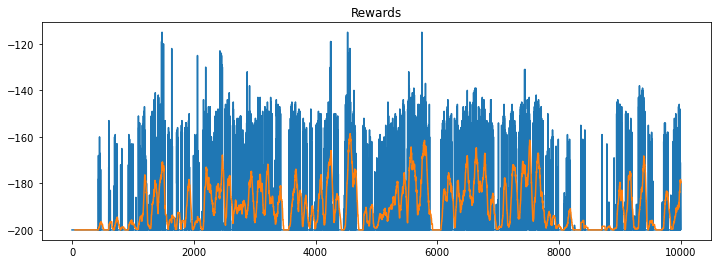

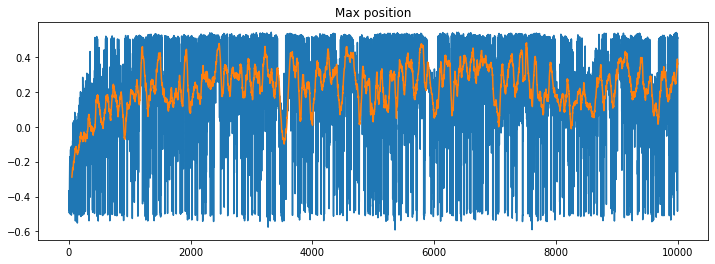

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Rewards")
pd.Series(rewards).plot(kind='line')
pd.Series(rewards).rolling(window=50).mean().plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Max position")    
pd.Series(max_positions).plot(kind='line')
pd.Series(max_positions).rolling(window=50).mean().plot(kind='line')
plt.show()

In [17]:
n_episodes = 1000
eval_rewards, eval_max_positions = evaluate(
    agent, env, n_episodes)

100%|██████████| 1000/1000 [01:29<00:00, 11.23it/s]


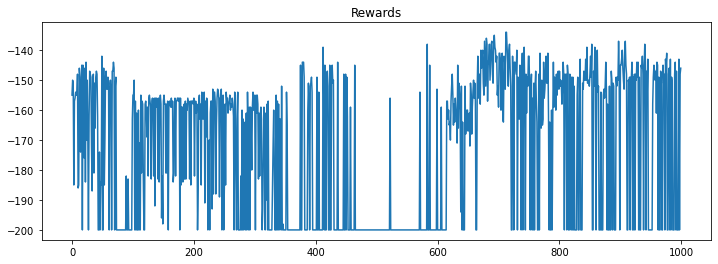

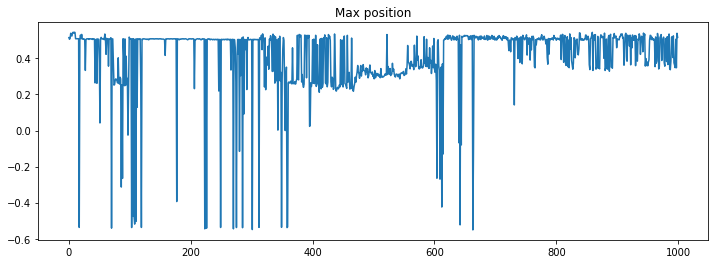

In [18]:
import pandas as pd

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Rewards")    
pd.Series(eval_rewards).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Max position")    
pd.Series(eval_max_positions).plot(kind='line')
plt.show()

In [19]:
n_completed = sum([1 if m > 0.5 else 0 for m in eval_max_positions])
print(f'{n_completed} success out of {n_episodes} attempts')

599 success out of 1000 attempts


SARSA is an on-policy algorithm you can use in tabular environments.

Small continuous environments can be treated as tabular, using a discretization of the state, and then solved with tabular SARSA or tabular Q-learning.

Larger environments cannot be discretized and solved because of the curse of dimensionality.

For more complex environments than MountainCarwe will need more advanced RL solutions.

Sometimes RL is not the best solution. Keep that in mind when you try to solve the problems you care about. Do not marry your tools (in this case RL), instead focus on finding a good solution. Do not miss the forest for the trees 🌲🌲🌲.